<a href="https://colab.research.google.com/github/samidardar/Customer-Segmentation-for-Enhanced-Profitability/blob/main/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd

df = pd.read_excel('/content/online_retail_II.xlsx')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [2]:
print(f"Initial DataFrame shape: {df.shape}")

# 1. Handle missing values in 'Customer ID'
df.dropna(subset=['Customer ID'], inplace=True)
print(f"DataFrame shape after dropping rows with missing Customer ID: {df.shape}")

# 2. Convert 'InvoiceDate' to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
print("InvoiceDate column converted to datetime.")

# 3. Remove rows with negative or zero 'Quantity'
df = df[df['Quantity'] > 0]
print(f"DataFrame shape after removing non-positive Quantity: {df.shape}")

# 4. Remove rows with negative or zero 'Price'
df = df[df['Price'] > 0]
print(f"DataFrame shape after removing non-positive Price: {df.shape}")

# 5. Create 'TotalPrice' column
df['TotalPrice'] = df['Quantity'] * df['Price']
print("TotalPrice column created.")

print(f"Final DataFrame shape: {df.shape}")
df.head()

Initial DataFrame shape: (525461, 8)
DataFrame shape after dropping rows with missing Customer ID: (417534, 8)
InvoiceDate column converted to datetime.
DataFrame shape after removing non-positive Quantity: (407695, 8)
DataFrame shape after removing non-positive Price: (407664, 8)
TotalPrice column created.
Final DataFrame shape: (407664, 9)


,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,100.8
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.0


In [3]:
snapshot_date = df['InvoiceDate'].max() + pd.DateOffset(days=1)
print(f"Snapshot Date: {snapshot_date}")

Snapshot Date: 2010-12-10 20:01:00


In [4]:
rfm_df = df.groupby('Customer ID').agg(
    Recency=('InvoiceDate', lambda date: (snapshot_date - date.max()).days),
    Frequency=('Invoice', 'nunique'),
    Monetary=('TotalPrice', 'sum')
)

print("RFM DataFrame created.")
rfm_df.head()

RFM DataFrame created.


,Recency,Frequency,Monetary
Customer ID,,,
12346.0,165,11,372.86
12347.0,3,2,1323.32
12348.0,74,1,222.16
12349.0,43,3,2671.14
12351.0,11,1,300.93


RFM features standardized.
WCSS values calculated for K from 1 to 10.


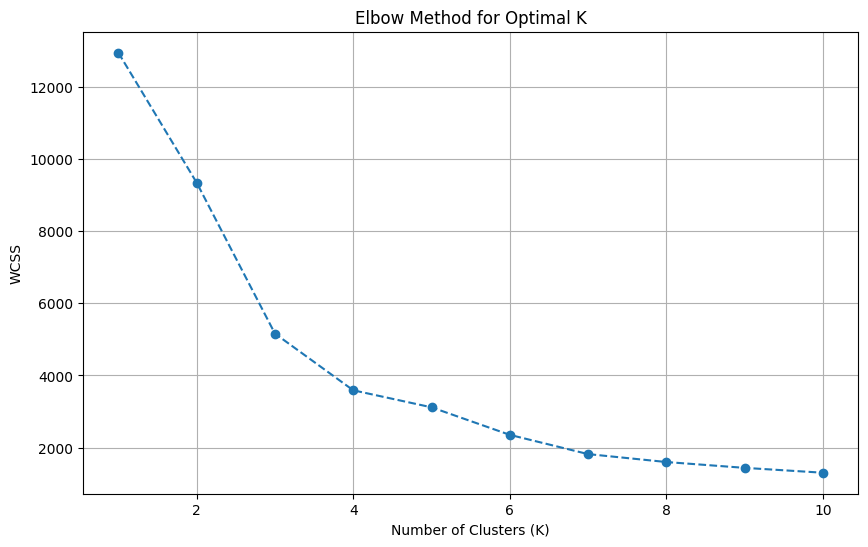

Elbow Method plot displayed.


In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# 1. Standardize the RFM features
scaler = StandardScaler()
rfm_scaled_df = scaler.fit_transform(rfm_df[['Recency', 'Frequency', 'Monetary']])
rfm_scaled_df = pd.DataFrame(rfm_scaled_df, columns=['Recency', 'Frequency', 'Monetary'], index=rfm_df.index)
print("RFM features standardized.")

# 2. Initialize an empty list to store WCSS values
wcss = []

# 3. Iterate through a range of K values (1 to 10)
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(rfm_scaled_df)
    wcss.append(kmeans.inertia_)
print("WCSS values calculated for K from 1 to 10.")

# 4. Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()
print("Elbow Method plot displayed.")

#### Optimal K Determination

Based on the Elbow Method plot, the optimal number of clusters (K) appears to be **3**, as this is where the decrease in WCSS (Within-Cluster Sum of Squares) starts to level off significantly. While K=4 also shows a noticeable bend, K=3 provides a good balance between minimizing WCSS and having a manageable number of distinct customer segments.

In [6]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
rfm_df['Cluster'] = kmeans.fit_predict(rfm_scaled_df)
print("K-means clustering applied and cluster labels added to rfm_df.")
rfm_df.head()

K-means clustering applied and cluster labels added to rfm_df.


,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
12346.0,165,11,372.86,1
12347.0,3,2,1323.32,0
12348.0,74,1,222.16,0
12349.0,43,3,2671.14,0
12351.0,11,1,300.93,0


In [7]:
cluster_analysis = rfm_df.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()
print("Mean RFM values for each cluster:")
print(cluster_analysis)


Mean RFM values for each cluster:
            Recency   Frequency       Monetary
Cluster                                       
0         42.264279    4.942575    2082.315956
1        241.683019    1.654717     594.019655
2          4.230769  111.538462  112132.389231


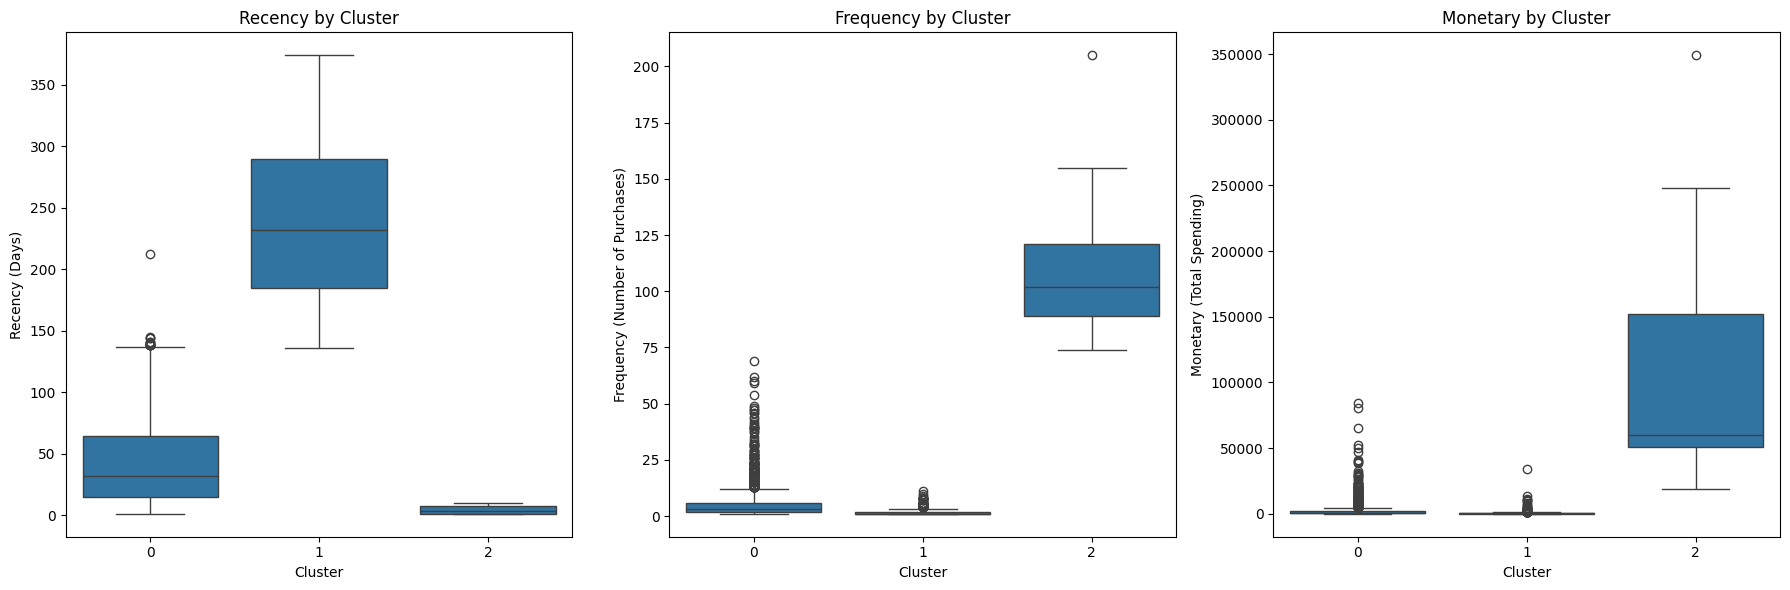

Box plots for Recency, Frequency, and Monetary by Cluster displayed.


In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='Cluster', y='Recency', data=rfm_df, ax=axes[0])
axes[0].set_title('Recency by Cluster')
axes[0].set_xlabel('Cluster')
axes[0].set_ylabel('Recency (Days)')

sns.boxplot(x='Cluster', y='Frequency', data=rfm_df, ax=axes[1])
axes[1].set_title('Frequency by Cluster')
axes[1].set_xlabel('Cluster')
axes[1].set_ylabel('Frequency (Number of Purchases)')

sns.boxplot(x='Cluster', y='Monetary', data=rfm_df, ax=axes[2])
axes[2].set_title('Monetary by Cluster')
axes[2].set_xlabel('Cluster')
axes[2].set_ylabel('Monetary (Total Spending)')

plt.tight_layout()
plt.show()
print("Box plots for Recency, Frequency, and Monetary by Cluster displayed.")

### Customer Segment Analysis

Based on the mean RFM values and the box plots, we can characterize the three customer segments as follows:

*   **Cluster 0 (Engaged Customers)**:
    *   **Recency (Mean: 42 days)**: This cluster has a moderate recency, meaning their last purchase was relatively recent but not as immediate as Cluster 2.
    *   **Frequency (Mean: 4.9 purchases)**: They show a good frequency of purchases, suggesting they are repeat customers.
    *   **Monetary (Mean: $2082)**: They have a significantly higher monetary value compared to Cluster 1, indicating they spend a decent amount.
    *   **Characteristics**: These are valuable customers who purchase regularly and spend well. They are engaged but might need occasional nudges to prevent them from becoming 'at-risk'.
    *   **Marketing Implications**: Focus on retention strategies, personalized offers, and loyalty programs to maintain their engagement and increase their lifetime value. Encourage them to explore new products.

*   **Cluster 1 (At-Risk/Lapsed Customers)**:
    *   **Recency (Mean: 242 days)**: This cluster has the highest recency, meaning they haven't purchased in a long time. This is a clear indicator of lapsed or at-risk customers.
    *   **Frequency (Mean: 1.6 purchases)**: Their frequency is low, suggesting they are not frequent buyers or have significantly reduced their purchasing activity.
    *   **Monetary (Mean: $594)**: They have the lowest monetary value among the clusters, reinforcing their status as less active spenders.
    *   **Characteristics**: These customers are likely lapsing or have already lapsed. They might have made a few purchases but haven't returned recently.
    *   **Marketing Implications**: Implement win-back campaigns, offer incentives or special discounts to re-engage them, and investigate reasons for their inactivity. Personalized re-engagement emails or offers on past favorite items could be effective.

*   **Cluster 2 (Best/High-Value Customers)**:
    *   **Recency (Mean: 4.2 days)**: This cluster has the lowest recency, indicating they have purchased very recently.
    *   **Frequency (Mean: 111.5 purchases)**: They exhibit extremely high frequency, making them the most frequent buyers.
    *   **Monetary (Mean: $112,132)**: This cluster has an exceptionally high monetary value, far exceeding the other clusters. These are clearly the top spenders.
    *   **Characteristics**: These are the brand's most valuable and loyal customers. They buy often and spend a lot of money.
    *   **Marketing Implications**: Reward their loyalty with exclusive access, VIP programs, personalized recommendations, and excellent customer service. Encourage advocacy and referrals. Prioritize retention and aim to maintain their high engagement.

### Customer Segment Analysis

Based on the mean RFM values and the box plots, we can characterize the three customer segments as follows:

*   **Cluster 0 (Engaged Customers)**:
    *   **Recency (Mean: 42 days)**: This cluster has a moderate recency, meaning their last purchase was relatively recent but not as immediate as Cluster 2.
    *   **Frequency (Mean: 4.9 purchases)**: They show a good frequency of purchases, suggesting they are repeat customers.
    *   **Monetary (Mean: $2082)**: They have a significantly higher monetary value compared to Cluster 1, indicating they spend a decent amount.
    *   **Characteristics**: These are valuable customers who purchase regularly and spend well. They are engaged but might need occasional nudges to prevent them from becoming 'at-risk'.
    *   **Marketing Implications**: Focus on retention strategies, personalized offers, and loyalty programs to maintain their engagement and increase their lifetime value. Encourage them to explore new products.

*   **Cluster 1 (At-Risk/Lapsed Customers)**:
    *   **Recency (Mean: 242 days)**: This cluster has the highest recency, meaning they haven't purchased in a long time. This is a clear indicator of lapsed or at-risk customers.
    *   **Frequency (Mean: 1.6 purchases)**: Their frequency is low, suggesting they are not frequent buyers or have significantly reduced their purchasing activity.
    *   **Monetary (Mean: $594)**: They have the lowest monetary value among the clusters, reinforcing their status as less active spenders.
    *   **Characteristics**: These customers are likely lapsing or have already lapsed. They might have made a few purchases but haven't returned recently.
    *   **Marketing Implications**: Implement win-back campaigns, offer incentives or special discounts to re-engage them, and investigate reasons for their inactivity. Personalized re-engagement emails or offers on past favorite items could be effective.

*   **Cluster 2 (Best/High-Value Customers)**:
    *   **Recency (Mean: 4.2 days)**: This cluster has the lowest recency, indicating they have purchased very recently.
    *   **Frequency (Mean: 111.5 purchases)**: They exhibit extremely high frequency, making them the most frequent buyers.
    *   **Monetary (Mean: $112,132)**: This cluster has an exceptionally high monetary value, far exceeding the other clusters. These are clearly the top spenders.
    *   **Characteristics**: These are the brand's most valuable and loyal customers. They buy often and spend a lot of money.
    *   **Marketing Implications**: Reward their loyalty with exclusive access, VIP programs, personalized recommendations, and excellent customer service. Encourage advocacy and referrals. Prioritize retention and aim to maintain their high engagement.

## Summary:

### Q&A

**1. What are the identified customer segments, detailing their typical spending patterns and behavior?**

Three distinct customer segments were identified through RFM analysis and K-means clustering:

*   **Cluster 0 (Engaged Customers):** These customers have a moderate recency (average of 42 days since last purchase), good frequency (average of 4.9 purchases), and decent monetary value (average spending of \$2082). They are valuable, regular spenders who are engaged but might need occasional prompts.
*   **Cluster 1 (At-Risk/Lapsed Customers):** This segment shows high recency (average of 242 days since last purchase), low frequency (average of 1.6 purchases), and the lowest monetary value (average spending of \$594). They are likely lapsing or have already lapsed, showing significantly reduced purchasing activity.
*   **Cluster 2 (Best/High-Value Customers):** This cluster represents the most valuable customers with very low recency (average of 4.2 days since last purchase), exceptionally high frequency (average of 111.5 purchases), and extremely high monetary value (average spending of \$112,132). They are the brand's most loyal and highest-spending customers.

**2. What are the potential implications for marketing strategies for each segment?**

*   **For Engaged Customers (Cluster 0):** Marketing strategies should focus on retention, personalized offers, and loyalty programs to maintain their engagement and increase their lifetime value. Encouraging them to explore new products is also key.
*   **For At-Risk/Lapsed Customers (Cluster 1):** Implement win-back campaigns, offer incentives or special discounts to re-engage them, and investigate reasons for their inactivity. Personalized re-engagement emails or offers on past favorite items could be effective.
*   **For Best/High-Value Customers (Cluster 2):** Reward their loyalty with exclusive access, VIP programs, personalized recommendations, and excellent customer service. Encourage advocacy and referrals, while prioritizing retention to maintain their high engagement.

### Data Analysis Key Findings

*   The initial dataset of 525,461 rows was cleaned, resulting in 407,664 valid transactions after removing missing customer IDs, non-positive quantities, and prices.
*   A `TotalPrice` column was successfully created by multiplying `Quantity` and `Price`.
*   RFM features were calculated with a snapshot date of `2010-12-10 20:01:00`.
    *   Recency: Days since last purchase.
    *   Frequency: Number of unique invoices.
    *   Monetary: Total spending.
*   The Elbow Method identified **3** as the optimal number of clusters for customer segmentation.
*   K-means clustering successfully segmented customers into three distinct groups based on their RFM characteristics.
*   **Cluster 2 (Best/High-Value Customers)** stands out significantly with the highest average Monetary value (\$112,132) and Frequency (111.5 purchases), and the lowest average Recency (4.2 days).
*   **Cluster 1 (At-Risk/Lapsed Customers)** has the highest average Recency (242 days) and the lowest average Monetary value (\$594) and Frequency (1.6 purchases).

### Insights or Next Steps

*   The distinct characteristics of the three customer segments provide a clear framework for tailored marketing campaigns, enabling more efficient resource allocation and personalized customer engagement strategies.
*   Further analysis could involve investigating the products purchased by each segment to refine product-specific recommendations and target inventory management, especially for high-value customers.


In [10]:
sample_customer_ids = rfm_df.groupby('Cluster').apply(lambda x: x.sample(n=3, random_state=42).index)
print("Sampled customer IDs from each cluster:")
print(sample_customer_ids)

Sampled customer IDs from each cluster:
Cluster
0    Index([13952.0, 16770.0, 14978.0], dtype='floa...
1    Index([17915.0, 14207.0, 12784.0], dtype='floa...
2    Index([17949.0, 17841.0, 12748.0], dtype='floa...
dtype: object


/tmp/ipython-input-1880420893.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_customer_ids = rfm_df.groupby('Cluster').apply(lambda x: x.sample(n=3, random_state=42).index)


In [11]:
import numpy as np

# Flatten the Series of Index objects into a single list of customer IDs
flat_sample_ids = [idx for sub_idx in sample_customer_ids for idx in sub_idx]

# Create a new DataFrame with RFM values and cluster assignments for the sampled customers
sampled_rfm_df = rfm_df.loc[flat_sample_ids]

print("DataFrame with RFM values and cluster assignments for sampled customers created:")
sampled_rfm_df

DataFrame with RFM values and cluster assignments for sampled customers created:


,Recency,Frequency,Monetary,Cluster
Customer ID,,,,
13952.0,16,12,9572.45,0
16770.0,8,5,1162.03,0
14978.0,66,5,1210.72,0
17915.0,187,1,242.13,1
14207.0,323,1,157.80,1
12784.0,165,1,1230.33,1
17949.0,7,74,60117.60,2
17841.0,1,91,29892.50,2
12748.0,1,144,22879.66,2


# Task
The customer segments identified through RFM analysis and K-means clustering are as follows:

*   **Cluster 0 (Engaged Customers):**
    *   **Recency (Mean: 42 days)**: Their last purchase was relatively recent.
    *   **Frequency (Mean: 4.9 purchases)**: They show a good frequency of purchases.
    *   **Monetary (Mean: $2082)**: They have a decent monetary value.
    *   **Characteristics**: These are valuable customers who purchase regularly and spend well, but might need occasional prompts to maintain engagement.
    *   **Marketing Implications**: Focus on retention strategies, personalized offers, and loyalty programs. Encourage them to explore new products.

*   **Cluster 1 (At-Risk/Lapsed Customers)**:
    *   **Recency (Mean: 242 days)**: They haven't purchased in a long time.
    *   **Frequency (Mean: 1.6 purchases)**: Their frequency is low.
    *   **Monetary (Mean: $594)**: They have the lowest monetary value.
    *   **Characteristics**: These customers are likely lapsing or have already lapsed.
    *   **Marketing Implications**: Implement win-back campaigns, offer incentives or special discounts to re-engage them, and investigate reasons for their inactivity.

*   **Cluster 2 (Best/High-Value Customers)**:
    *   **Recency (Mean: 4.2 days)**: They have purchased very recently.
    *   **Frequency (Mean: 111.5 purchases)**: They exhibit extremely high frequency.
    *   **Monetary (Mean: $112,132)**: They have an exceptionally high monetary value.
    *   **Characteristics**: These are the brand's most valuable and loyal customers.
    *   **Marketing Implications**: Reward their loyalty with exclusive access, VIP programs, personalized recommendations, and excellent customer service. Encourage advocacy and referrals, and prioritize retention.

## Summary:

### Q&A
The customer segments identified are: Engaged Customers, At-Risk/Lapsed Customers, and Best/High-Value Customers.

*   **Engaged Customers (Cluster 0)**:
    *   **Spending Patterns**: Their last purchase was relatively recent (mean of 42 days), they show a good frequency of purchases (mean of 4.9 purchases), and have a decent monetary value (mean of \$2082).
    *   **Behavior**: They are valuable customers who purchase regularly and spend well, but might require occasional prompts to maintain their engagement.
    *   **Marketing Implications**: Focus on retention strategies, personalized offers, and loyalty programs to encourage continued engagement and exploration of new products.

*   **At-Risk/Lapsed Customers (Cluster 1)**:
    *   **Spending Patterns**: They haven't purchased in a long time (mean of 242 days since last purchase), have a low frequency (mean of 1.6 purchases), and the lowest monetary value (mean of \$594).
    *   **Behavior**: These customers are likely lapsing or have already lapsed from the customer base.
    *   **Marketing Implications**: Implement win-back campaigns, offer incentives or special discounts to re-engage them, and investigate the reasons behind their inactivity.

*   **Best/High-Value Customers (Cluster 2)**:
    *   **Spending Patterns**: They have purchased very recently (mean of 4.2 days), exhibit an extremely high frequency (mean of 111.5 purchases), and an exceptionally high monetary value (mean of \$112,132).
    *   **Behavior**: These are the brand's most valuable and loyal customers, demonstrating consistent and significant purchasing.
    *   **Marketing Implications**: Reward their loyalty with exclusive access, VIP programs, personalized recommendations, and excellent customer service. Prioritize their retention and encourage advocacy and referrals.

### Data Analysis Key Findings
*   **Best/High-Value Customers (Cluster 2)** are the most critical segment, characterized by very recent purchases (4.2 days), extremely high frequency (111.5 purchases), and exceptional monetary value (\$112,132), indicating strong loyalty and significant contribution.
*   **Engaged Customers (Cluster 0)** represent a valuable segment with recent activity (42 days), good frequency (4.9 purchases), and decent spending (\$2082), requiring sustained engagement efforts.
*   **At-Risk/Lapsed Customers (Cluster 1)** show significant disengagement, with purchases made long ago (242 days), low frequency (1.6 purchases), and the lowest monetary value (\$594), signaling a need for re-engagement strategies.

### Insights or Next Steps
*   Allocate a significant portion of marketing resources to nurturing **Best/High-Value Customers (Cluster 2)** through exclusive offers and VIP programs to maximize their lifetime value and leverage them for brand advocacy.
*   Develop targeted re-engagement campaigns with strong incentives for **At-Risk/Lapsed Customers (Cluster 1)** to prevent further churn and potentially reactivate a portion of this segment.
